Here, we will continue to use consumer complaints data from the Consumer Complaint Database (CFPB) that was used in the Wranging Data in the Tidyverse Course Project. The CFPB is an independent agency of the United States government that promotes transparency and protects consumers by providing information needed to make decisions when choosing financial institutions including banking institutions, lenders, mortgage services, credit unions, securities firms, foreclosure services, and debt collectors. One of the purposes of the agency is to receive and process complaints and questions about consumer financial products and services. 

When a complaint is submitted by a consumer, the CFPB has to determine which category the complaint falls in (e.g. "Mortgage", "Student loan", etc). In this project, your goal will be to use the skills you have learned about in this course to build a classification algorithm to classify consumer complaints into one of four categories: "Credit card or prepaid card", "Mortgage", "Student loan", or "Vehicle loan or lease". 

The goal of your project is to predict the consumer complaint category. This is the "Product" variable in the training data set. You may use any of the other variables to predict with. You should create a report describing how you built your model, how you used cross validation, what you think the expected out of sample error is, and why you made the choices you did. You will also use your prediction model to predict 20 different test cases. 

### Import Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
import shap
import statsmodels.api as sm
import datetime
from datetime import datetime, timedelta
import scipy.stats
import pandas_profiling
from pandas_profiling import ProfileReport

import xgboost as xgb
from xgboost import XGBClassifier, XGBRegressor
from xgboost import to_graphviz, plot_importance

#from sklearn.experimental import enable_hist_gradient_boosting
#from sklearn.linear_model import ElasticNet, Lasso, LinearRegression, LogisticRegression, Ridge
#from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor, ExtraTreesClassifier, ExtraTreesRegressor
#from sklearn.ensemble import GradientBoostingClassifier, GradientBoostingRegressor, HistGradientBoostingClassifier, HistGradientBoostingRegressor


%matplotlib inline
#sets the default autosave frequency in seconds
%autosave 60 
sns.set_style('dark')
sns.set(font_scale=1.2)

plt.rc('axes', labelsize=14)
plt.rc('xtick', labelsize=12)
plt.rc('ytick', labelsize=12)


#from sklearn.pipeline import Pipeline
#from sklearn.model_selection import RepeatedStratifiedKFold
#from sklearn.feature_selection import RFE, RFECV, SelectKBest, f_classif, f_regression, chi2

from sklearn.inspection import permutation_importance
from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix, classification_report, mean_absolute_error, mean_squared_error,r2_score
from sklearn.metrics import plot_confusion_matrix, plot_precision_recall_curve, plot_roc_curve, accuracy_score
from sklearn.metrics import auc, f1_score, precision_score, recall_score, roc_auc_score


#import feature_engine.missing_data_imputers as mdi
#from feature_engine.outlier_removers import Winsorizer

#from tpot import TPOTClassifier, TPOTRegressor
#from imblearn.under_sampling import RandomUnderSampler
#from imblearn.over_sampling import RandomOverSampler
#from imblearn.over_sampling import SMOTE

import warnings
warnings.filterwarnings('ignore')

import pickle
from pickle import dump, load

#Use Folium library to plot values on a map.
#import folium


np.random.seed(0)

from pycaret.classification import *
#from pycaret.clustering import *
#from pycaret.regression import *

pd.set_option('display.max_columns',100)
#pd.set_option('display.max_rows',100)
pd.set_option('display.width', 1000)
pd.option_context('float_format', '{:.2f}'.format)
np.set_printoptions(suppress=True)

Autosaving every 60 seconds


### Data Exploration and Analysis

In [2]:
df = pd.read_csv("data_complaints_train.csv")

In [3]:
df

,Product,Consumercomplaintnarrative,Company,State,ZIPcode,Submittedvia
0,Credit card or prepaid card,I initially in writing to Chase Bank in late X...,JPMORGAN CHASE & CO.,CT,064XX,Web
1,Mortgage,My ex husband and myself had a mobile home ( H...,Ditech Financial LLC,GA,None,Web
2,Student loan,I was a student at XXXX XXXX from XX/XX/XXXX-X...,"Navient Solutions, LLC.",IN,463XX,Web
3,Credit card or prepaid card,It has come to my attention the CITI group is ...,"CITIBANK, N.A.",MI,490XX,Web
4,Credit card or prepaid card,This banks new firearm policies run counter to...,"CITIBANK, N.A.",MI,480XX,Web
...,...,...,...,...,...,...
90970,Credit card or prepaid card,This involves a Chase Advantage ( checking ) a...,JPMORGAN CHASE & CO.,WV,260XX,Web
90971,Vehicle loan or lease,"I sent a letter to XXXX in XXXX, with signatu...","Byrider Franchising, LLC",LA,703XX,Web
90972,Student loan,One component of the PSLF program that I and s...,AES/PHEAA,VA,None,Web
90973,Credit card or prepaid card,i have been an american express customer for y...,AMERICAN EXPRESS COMPANY,NJ,None,Web


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90975 entries, 0 to 90974
Data columns (total 6 columns):
 #   Column                      Non-Null Count  Dtype 
---  ------                      --------------  ----- 
 0   Product                     90975 non-null  object
 1   Consumercomplaintnarrative  90975 non-null  object
 2   Company                     90975 non-null  object
 3   State                       90975 non-null  object
 4   ZIPcode                     90975 non-null  object
 5   Submittedvia                90975 non-null  object
dtypes: object(6)
memory usage: 4.2+ MB


In [5]:
df.describe(include='all')

,Product,Consumercomplaintnarrative,Company,State,ZIPcode,Submittedvia
count,90975,90975,90975,90975,90975,90975
unique,4,90237,1497,62,5484,1
top,Credit card or prepaid card,This particular account situation that is late...,"CITIBANK, N.A.",CA,None,Web
freq,38294,125,6520,13552,21892,90975


In [6]:
df.shape

(90975, 6)

In [7]:
df.columns

Index(['Product', 'Consumercomplaintnarrative', 'Company', 'State', 'ZIPcode', 'Submittedvia'], dtype='object')

### Sample 1000 observations first

In [8]:
df2 = df.sample(1000, random_state=0)

In [9]:
df2.head()

,Product,Consumercomplaintnarrative,Company,State,ZIPcode,Submittedvia
25325,Credit card or prepaid card,I signed up for AMEX XXXX XXXX that gives mone...,AMERICAN EXPRESS COMPANY,VA,None,Web
54404,Student loan,My daughter tried talking to Sallie Mae the le...,SLM CORPORATION,OR,972XX,Web
43878,Student loan,I tried numerous times to find a way to lower ...,"Navient Solutions, LLC.",MO,633XX,Web
22779,Credit card or prepaid card,I was reviewing my credit card activities and ...,Alliance Data Card Services,MD,207XX,Web
28642,Mortgage,I closed on a mortgage refinance loan on Monda...,"QUICKEN LOANS, INC.",TX,None,Web


### Data Visualization

### Univariate Data Exploration

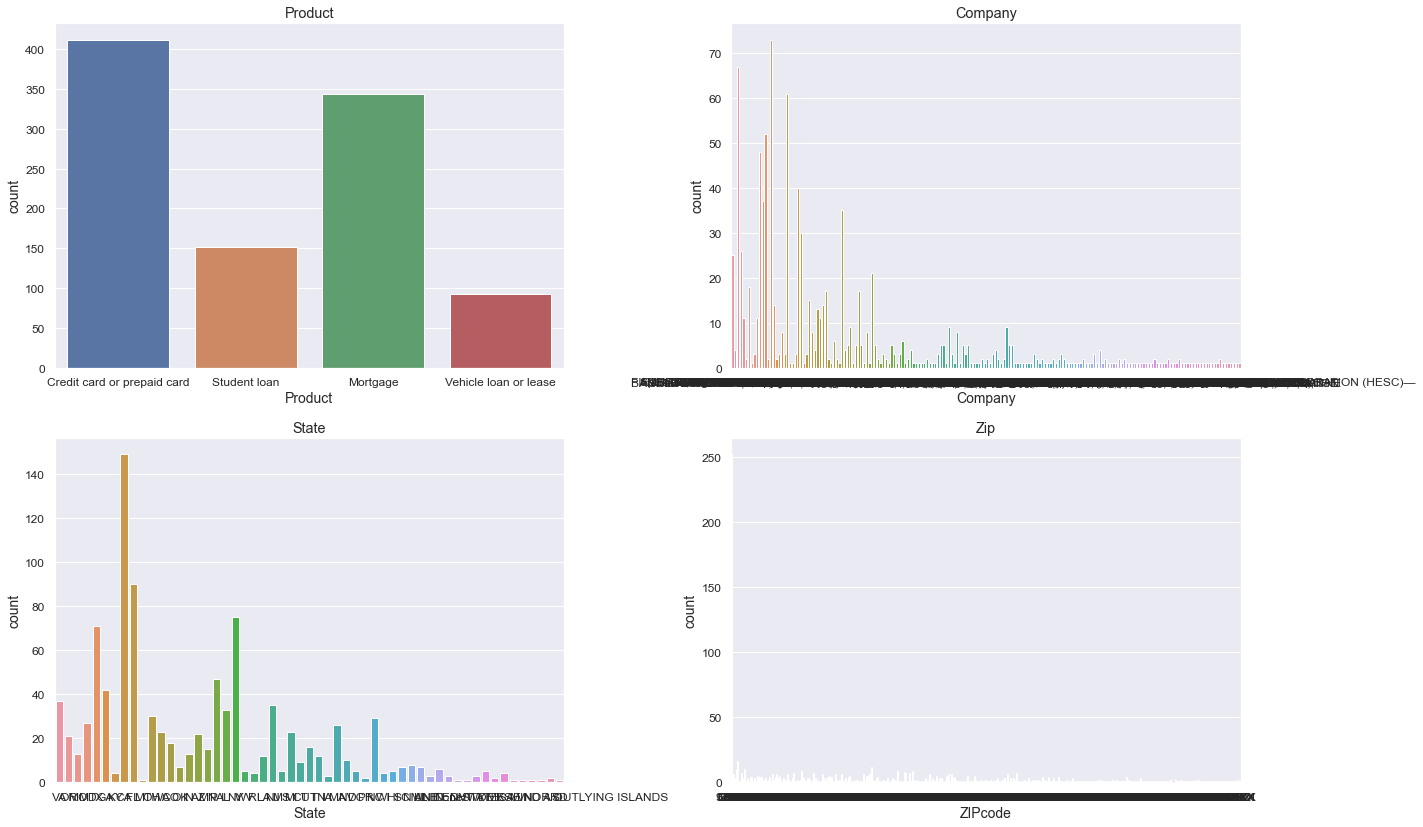

In [10]:
fig = plt.figure(figsize=(20,40))

plt.subplot(7,2,1)
plt.title("Product")
sns.countplot(df2.Product)

plt.subplot(7,2,2)
plt.title("Company")
sns.countplot(df2.Company)

plt.subplot(7,2,3)
plt.title("State")
sns.countplot(df2.State)

plt.subplot(7,2,4)
plt.title("Zip")
sns.countplot(df2.ZIPcode)



plt.tight_layout()
plt.show()

### Correlation

In [11]:
df.corr()

""


### Data Preprocessing

### Drop unwanted features

In [12]:
df.columns

Index(['Product', 'Consumercomplaintnarrative', 'Company', 'State', 'ZIPcode', 'Submittedvia'], dtype='object')

In [13]:
df.drop(['Submittedvia'], axis=1, inplace=True)

In [14]:
df

,Product,Consumercomplaintnarrative,Company,State,ZIPcode
0,Credit card or prepaid card,I initially in writing to Chase Bank in late X...,JPMORGAN CHASE & CO.,CT,064XX
1,Mortgage,My ex husband and myself had a mobile home ( H...,Ditech Financial LLC,GA,None
2,Student loan,I was a student at XXXX XXXX from XX/XX/XXXX-X...,"Navient Solutions, LLC.",IN,463XX
3,Credit card or prepaid card,It has come to my attention the CITI group is ...,"CITIBANK, N.A.",MI,490XX
4,Credit card or prepaid card,This banks new firearm policies run counter to...,"CITIBANK, N.A.",MI,480XX
...,...,...,...,...,...
90970,Credit card or prepaid card,This involves a Chase Advantage ( checking ) a...,JPMORGAN CHASE & CO.,WV,260XX
90971,Vehicle loan or lease,"I sent a letter to XXXX in XXXX, with signatu...","Byrider Franchising, LLC",LA,703XX
90972,Student loan,One component of the PSLF program that I and s...,AES/PHEAA,VA,None
90973,Credit card or prepaid card,i have been an american express customer for y...,AMERICAN EXPRESS COMPANY,NJ,None


In [15]:
df.drop(['Company'], axis=1, inplace=True)

In [16]:
df

,Product,Consumercomplaintnarrative,State,ZIPcode
0,Credit card or prepaid card,I initially in writing to Chase Bank in late X...,CT,064XX
1,Mortgage,My ex husband and myself had a mobile home ( H...,GA,None
2,Student loan,I was a student at XXXX XXXX from XX/XX/XXXX-X...,IN,463XX
3,Credit card or prepaid card,It has come to my attention the CITI group is ...,MI,490XX
4,Credit card or prepaid card,This banks new firearm policies run counter to...,MI,480XX
...,...,...,...,...
90970,Credit card or prepaid card,This involves a Chase Advantage ( checking ) a...,WV,260XX
90971,Vehicle loan or lease,"I sent a letter to XXXX in XXXX, with signatu...",LA,703XX
90972,Student loan,One component of the PSLF program that I and s...,VA,None
90973,Credit card or prepaid card,i have been an american express customer for y...,NJ,None


### Treat Missing Values

In [17]:
df.isnull().sum()

Product                       0
Consumercomplaintnarrative    0
State                         0
ZIPcode                       0
dtype: int64

### Treat Duplicate Values

In [18]:
df.duplicated(keep='first').sum()

355

In [19]:
df[df.duplicated(keep=False)] #Check duplicate values

,Product,Consumercomplaintnarrative,State,ZIPcode
549,Credit card or prepaid card,On XX/XX/XXXX I filed a dispute with Chase Ban...,None,None
1018,Student loan,Please provide any and all information regardi...,FL,32128
1119,Credit card or prepaid card,"To my dismay, on XX/XX/2019, through a decline...",KY,402XX
1222,Mortgage,"Hi, I have a very urgent matter once again due...",CA,956XX
1629,Credit card or prepaid card,I have not received confirmation not certified...,CA,913XX
...,...,...,...,...
89943,Vehicle loan or lease,In the past couple months this company allowed...,FL,338XX
90193,Credit card or prepaid card,I was shocked when I reviewed my credit report...,NY,112XX
90525,Credit card or prepaid card,My ex-girlfriend opened a credit card with me ...,TX,752XX
90674,Credit card or prepaid card,I was shocked when I reviewed my credit report...,NY,112XX


In [20]:
df.drop_duplicates(ignore_index=True, inplace=True)

In [21]:
df

,Product,Consumercomplaintnarrative,State,ZIPcode
0,Credit card or prepaid card,I initially in writing to Chase Bank in late X...,CT,064XX
1,Mortgage,My ex husband and myself had a mobile home ( H...,GA,None
2,Student loan,I was a student at XXXX XXXX from XX/XX/XXXX-X...,IN,463XX
3,Credit card or prepaid card,It has come to my attention the CITI group is ...,MI,490XX
4,Credit card or prepaid card,This banks new firearm policies run counter to...,MI,480XX
...,...,...,...,...
90615,Credit card or prepaid card,This involves a Chase Advantage ( checking ) a...,WV,260XX
90616,Vehicle loan or lease,"I sent a letter to XXXX in XXXX, with signatu...",LA,703XX
90617,Student loan,One component of the PSLF program that I and s...,VA,None
90618,Credit card or prepaid card,i have been an american express customer for y...,NJ,None


In [22]:
df.Product.value_counts()

Credit card or prepaid card    38033
Mortgage                       30943
Student loan                   12451
Vehicle loan or lease           9193
Name: Product, dtype: int64

In [23]:
df.ZIPcode.value_counts()

None     21836
300XX     1188
750XX      914
606XX      853
112XX      823
         ...  
27284        1
71303        1
8738         1
80936        1
90731        1
Name: ZIPcode, Length: 5484, dtype: int64

In [24]:
df.State.value_counts()

CA                                      13510
FL                                       8325
TX                                       7077
NY                                       5909
GA                                       4139
PA                                       3502
NJ                                       3484
IL                                       3292
VA                                       2890
NC                                       2646
MD                                       2559
MA                                       2457
OH                                       2450
AZ                                       2154
MI                                       2042
WA                                       1879
CO                                       1791
TN                                       1430
NV                                       1225
MO                                       1201
CT                                       1177
SC                                

In [25]:
df["zip3"] = df["ZIPcode"].str[:3]

In [26]:
df.head()

,Product,Consumercomplaintnarrative,State,ZIPcode,zip3
0,Credit card or prepaid card,I initially in writing to Chase Bank in late X...,CT,064XX,064
1,Mortgage,My ex husband and myself had a mobile home ( H...,GA,None,Non
2,Student loan,I was a student at XXXX XXXX from XX/XX/XXXX-X...,IN,463XX,463
3,Credit card or prepaid card,It has come to my attention the CITI group is ...,MI,490XX,490
4,Credit card or prepaid card,This banks new firearm policies run counter to...,MI,480XX,480


In [27]:
df["zip3"].unique()

array(['064', 'Non', '463', '490', '480', '331', '980', '913', '926',
       '238', '303', '852', '378', '751', '107', '481', '601', '923',
       '775', '956', '985', '333', '457', '600', '761', '018', '890',
       '455', '762', '860', '871', '563', '080', '282', '840', '782',
       '381', '920', '917', '704', '209', '633', '930', '722', '230',
       '211', '863', '174', '891', '294', '907', '731', '947', '272',
       '951', '661', '334', '286', '853', '113', '919', '281', '199',
       '088', '925', '223', '200', '902', '112', '076', '208', '329',
       '444', '836', '493', '631', '705', '283', '171', '918', '933',
       '937', '100', '328', '380', '190', '946', '483', '207', '363',
       '606', '117', '146', '201', '974', '210', '317', '805', '232',
       '341', '945', '221', '921', '770', '191', '988', '325', '740',
       '747', '029', '900', '140', '794', '781', '327', '275', '440',
       '935', '750', '727', '660', '320', '780', '855', '212', '635',
       '346', '981',

In [28]:
df.zip3.replace(to_replace='Non', value='000',inplace=True)

In [29]:
df.zip3.unique()

array(['064', '000', '463', '490', '480', '331', '980', '913', '926',
       '238', '303', '852', '378', '751', '107', '481', '601', '923',
       '775', '956', '985', '333', '457', '600', '761', '018', '890',
       '455', '762', '860', '871', '563', '080', '282', '840', '782',
       '381', '920', '917', '704', '209', '633', '930', '722', '230',
       '211', '863', '174', '891', '294', '907', '731', '947', '272',
       '951', '661', '334', '286', '853', '113', '919', '281', '199',
       '088', '925', '223', '200', '902', '112', '076', '208', '329',
       '444', '836', '493', '631', '705', '283', '171', '918', '933',
       '937', '100', '328', '380', '190', '946', '483', '207', '363',
       '606', '117', '146', '201', '974', '210', '317', '805', '232',
       '341', '945', '221', '921', '770', '191', '988', '325', '740',
       '747', '029', '900', '140', '794', '781', '327', '275', '440',
       '935', '750', '727', '660', '320', '780', '855', '212', '635',
       '346', '981',

In [30]:
df["Consumercomplaintnarrative"] = df["Consumercomplaintnarrative"].str.strip()

In [31]:
df.head()

,Product,Consumercomplaintnarrative,State,ZIPcode,zip3
0,Credit card or prepaid card,I initially in writing to Chase Bank in late X...,CT,064XX,064
1,Mortgage,My ex husband and myself had a mobile home ( H...,GA,None,000
2,Student loan,I was a student at XXXX XXXX from XX/XX/XXXX-X...,IN,463XX,463
3,Credit card or prepaid card,It has come to my attention the CITI group is ...,MI,490XX,490
4,Credit card or prepaid card,This banks new firearm policies run counter to...,MI,480XX,480


In [32]:
df["Consumercomplaintnarrative"].replace(" ","", inplace=True)

In [33]:
df.head()

,Product,Consumercomplaintnarrative,State,ZIPcode,zip3
0,Credit card or prepaid card,I initially in writing to Chase Bank in late X...,CT,064XX,064
1,Mortgage,My ex husband and myself had a mobile home ( H...,GA,None,000
2,Student loan,I was a student at XXXX XXXX from XX/XX/XXXX-X...,IN,463XX,463
3,Credit card or prepaid card,It has come to my attention the CITI group is ...,MI,490XX,490
4,Credit card or prepaid card,This banks new firearm policies run counter to...,MI,480XX,480


In [34]:
df["length"] = df.Consumercomplaintnarrative.str.len()

In [35]:
df

,Product,Consumercomplaintnarrative,State,ZIPcode,zip3,length
0,Credit card or prepaid card,I initially in writing to Chase Bank in late X...,CT,064XX,064,813
1,Mortgage,My ex husband and myself had a mobile home ( H...,GA,None,000,2656
2,Student loan,I was a student at XXXX XXXX from XX/XX/XXXX-X...,IN,463XX,463,966
3,Credit card or prepaid card,It has come to my attention the CITI group is ...,MI,490XX,490,520
4,Credit card or prepaid card,This banks new firearm policies run counter to...,MI,480XX,480,506
...,...,...,...,...,...,...
90615,Credit card or prepaid card,This involves a Chase Advantage ( checking ) a...,WV,260XX,260,1455
90616,Vehicle loan or lease,"I sent a letter to XXXX in XXXX, with signatu...",LA,703XX,703,939
90617,Student loan,One component of the PSLF program that I and s...,VA,None,000,878
90618,Credit card or prepaid card,i have been an american express customer for y...,NJ,None,000,634


In [36]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90620 entries, 0 to 90619
Data columns (total 6 columns):
 #   Column                      Non-Null Count  Dtype 
---  ------                      --------------  ----- 
 0   Product                     90620 non-null  object
 1   Consumercomplaintnarrative  90620 non-null  object
 2   State                       90620 non-null  object
 3   ZIPcode                     90620 non-null  object
 4   zip3                        90620 non-null  object
 5   length                      90620 non-null  int64 
dtypes: int64(1), object(5)
memory usage: 4.1+ MB


In [37]:
df["zip3"] = df["zip3"].astype("int")

In [38]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90620 entries, 0 to 90619
Data columns (total 6 columns):
 #   Column                      Non-Null Count  Dtype 
---  ------                      --------------  ----- 
 0   Product                     90620 non-null  object
 1   Consumercomplaintnarrative  90620 non-null  object
 2   State                       90620 non-null  object
 3   ZIPcode                     90620 non-null  object
 4   zip3                        90620 non-null  int32 
 5   length                      90620 non-null  int64 
dtypes: int32(1), int64(1), object(4)
memory usage: 3.8+ MB


In [39]:
df.columns

Index(['Product', 'Consumercomplaintnarrative', 'State', 'ZIPcode', 'zip3', 'length'], dtype='object')

In [40]:
df.drop(['Consumercomplaintnarrative','ZIPcode'], axis=1, inplace=True)

In [41]:
df.head()

,Product,State,zip3,length
0,Credit card or prepaid card,CT,64,813
1,Mortgage,GA,0,2656
2,Student loan,IN,463,966
3,Credit card or prepaid card,MI,490,520
4,Credit card or prepaid card,MI,480,506


In [42]:
df.State.unique()

array(['CT', 'GA', 'IN', 'MI', 'FL', 'WA', 'CA', 'VA', 'AZ', 'NY', 'TN',
       'TX', 'IL', 'IA', 'OH', 'MA', 'NV', 'NM', 'MN', 'NJ', 'NC', 'UT',
       'AL', 'LA', 'MD', 'MO', 'AR', 'PA', 'SC', 'OK', 'KS', 'CO', 'DE',
       'DC', 'WI', 'AK', 'ID', 'ME', 'OR', 'NH', 'RI', 'KY', 'HI', 'MS',
       'VT', 'UNITED STATES MINOR OUTLYING ISLANDS', 'SD', 'WV', 'None',
       'ND', 'MT', 'PR', 'NE', 'WY', 'AP', 'GU', 'AE', 'VI', 'AA', 'AS',
       'FM', 'MH'], dtype=object)

### Create and save processed dataset

In [43]:
#df.to_csv("cleaned.csv",index=False)

### Model Training

In [44]:
df.shape

(90620, 4)

In [45]:
df2 = df.sample(10000, random_state=0)
df2

,Product,State,zip3,length
7750,Credit card or prepaid card,NY,105,1346
31506,Mortgage,TX,781,580
42204,Mortgage,NC,288,2165
72159,Credit card or prepaid card,CA,930,448
71704,Credit card or prepaid card,NY,103,1147
...,...,...,...,...
38534,Student loan,VA,223,1968
18665,Student loan,VA,0,1192
51124,Credit card or prepaid card,MA,18,960
17145,Credit card or prepaid card,TX,787,3413


### Using PyCaret

In [46]:
exp_reg = setup(data = df2, target = 'Product', session_id=0, normalize=True, numeric_features=['zip3']) 

,Description,Value
0,session_id,0
1,Target,Product
2,Target Type,Multiclass
3,Label Encoded,"Credit card or prepaid card: 0, Mortgage: 1, Student loan: 2, Vehicle loan or lease: 3"
4,Original Data,"(10000, 4)"
5,Missing Values,False
6,Numeric Features,2
7,Categorical Features,1
8,Ordinal Features,False
9,High Cardinality Features,False


In [47]:
compare_models(exclude=['catboost','lightgbm','lda','qda','mlp','nb','ridge'],fold=5)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
gbc,Gradient Boosting Classifier,0.4438,0.5800,0.2857,0.3845,0.3846,0.0862,0.0940,1.9240
lr,Logistic Regression,0.4339,0.5695,0.2718,0.3475,0.3583,0.0552,0.0657,1.2660
ada,Ada Boost Classifier,0.4338,0.5597,0.2785,0.3788,0.3750,0.0693,0.0751,0.2260
xgboost,Extreme Gradient Boosting,0.4193,0.5618,0.2795,0.3660,0.3775,0.0662,0.0691,3.0520
knn,K Neighbors Classifier,0.3993,0.5336,0.2676,0.3493,0.3606,0.0377,0.0394,0.1780
svm,SVM - Linear Kernel,0.3745,0.0000,0.2661,0.3570,0.3296,0.0342,0.0397,0.1340
rf,Random Forest Classifier,0.3682,0.5365,0.2743,0.3536,0.3600,0.0445,0.0446,0.5660
et,Extra Trees Classifier,0.3578,0.5264,0.2724,0.3493,0.3532,0.0372,0.0372,0.6300
dt,Decision Tree Classifier,0.3475,0.5172,0.2704,0.3469,0.3471,0.0333,0.0333,0.0660


GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=3,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=100,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=0, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

In [48]:
gbc = create_model('gbc')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.4529,0.5993,0.2906,0.3803,0.3921,0.1013,0.1111
1,0.4443,0.5704,0.2912,0.3840,0.3899,0.0897,0.0970
2,0.4286,0.5556,0.2783,0.4919,0.3714,0.0573,0.0629
3,0.4243,0.5772,0.2701,0.3281,0.3657,0.0539,0.0585
4,0.4386,0.5840,0.2805,0.3615,0.3791,0.0770,0.0840
5,0.4671,0.6071,0.3042,0.4444,0.4065,0.1223,0.1343
6,0.4243,0.5728,0.2776,0.3836,0.3710,0.0588,0.0630
7,0.4471,0.5869,0.2904,0.4104,0.3888,0.0929,0.1013
8,0.4386,0.5924,0.2804,0.3631,0.3765,0.0744,0.0819
9,0.4220,0.5776,0.2690,0.3433,0.3637,0.0497,0.0547


In [49]:
print(gbc)

GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=3,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=100,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=0, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)


In [50]:
tuned_gbc = tune_model( gbc, optimize='f1')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.4271,0.5784,0.2941,0.3861,0.3913,0.0852,0.0882
1,0.4114,0.5572,0.2781,0.3640,0.3742,0.0576,0.0599
2,0.4086,0.5471,0.2714,0.3588,0.3649,0.0427,0.0453
3,0.4357,0.5847,0.3121,0.4066,0.4052,0.1026,0.1058
4,0.4143,0.5607,0.2874,0.3771,0.3817,0.0668,0.0690
5,0.4386,0.5828,0.2927,0.3842,0.3952,0.0967,0.1010
6,0.4357,0.5700,0.3033,0.4031,0.4001,0.0989,0.1023
7,0.4371,0.5697,0.3020,0.4025,0.3995,0.0976,0.1019
8,0.4414,0.5703,0.2938,0.3830,0.3964,0.1011,0.1058
9,0.4134,0.5703,0.2731,0.3531,0.3729,0.0599,0.0623


In [51]:
print(tuned_gbc)

GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.241, loss='deviance', max_depth=3,
                           max_features='log2', max_leaf_nodes=None,
                           min_impurity_decrease=0.0005,
                           min_impurity_split=None, min_samples_leaf=1,
                           min_samples_split=2, min_weight_fraction_leaf=0.0,
                           n_estimators=240, n_iter_no_change=None,
                           presort='deprecated', random_state=0, subsample=0.5,
                           tol=0.0001, validation_fraction=0.1, verbose=0,
                           warm_start=False)


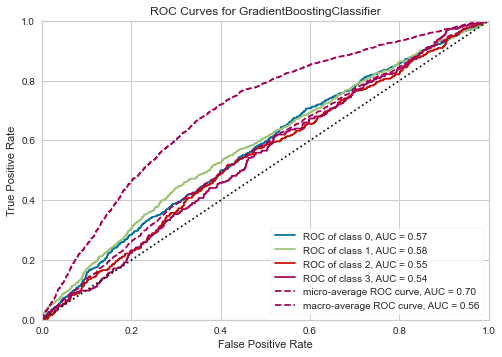

In [52]:
plot_model(tuned_gbc)

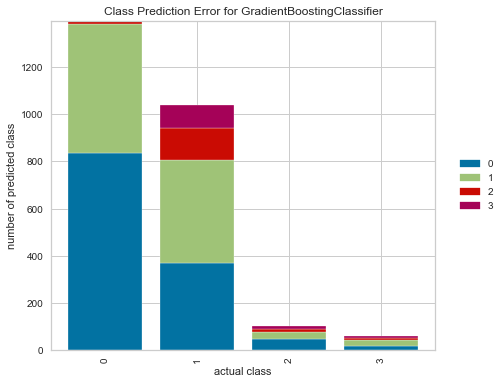

In [53]:
plot_model(tuned_gbc, plot = 'error')

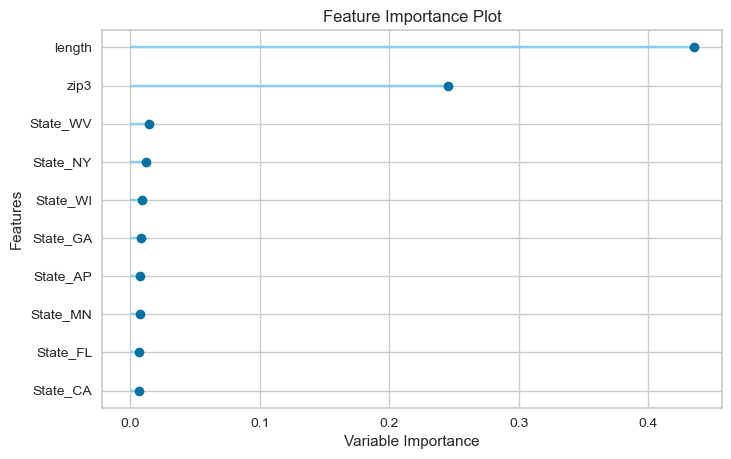

In [54]:
plot_model(tuned_gbc, plot='feature')

In [56]:
evaluate_model(tuned_gbc)

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Hyperparameters', 'param…

In [57]:
predict_model(tuned_gbc)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Gradient Boosting Classifier,0.4279,0.5684,0.2804,0.3640,0.3831,0.0771,0.0809


,zip3,length,State_AA,State_AE,State_AK,State_AL,State_AP,State_AR,State_AZ,State_CA,...,State_VA,State_VI,State_VT,State_WA,State_WI,State_WV,State_WY,Product,Label,Score
0,-0.359487,0.440433,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Vehicle loan or lease,Mortgage,0.4170
1,-0.495394,-0.378557,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,Student loan,Mortgage,0.4739
2,-1.155110,-0.351422,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Mortgage,Credit card or prepaid card,0.4234
3,0.351194,-0.380407,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,Credit card or prepaid card,Vehicle loan or lease,0.3322
4,1.112840,0.101243,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Credit card or prepaid card,Mortgage,0.5397
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2996,-0.871970,0.375062,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Credit card or prepaid card,Credit card or prepaid card,0.6140
2997,-0.220748,0.034638,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Mortgage,Mortgage,0.4851
2998,1.463934,-0.360055,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Mortgage,Credit card or prepaid card,0.4226
2999,1.540381,-0.287901,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Mortgage,Credit card or prepaid card,0.4626
